1. Acquisition of Stock Data

In [1]:
# Import all the required libraries.
import math
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Use the yFinance download method to acquire the stock data started from 1 Jan 2016 to 1 Oct 2021 and then preview the data.
stock_data = yf.download('AAPL', start='2016-01-01', end='2021-10-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.111496,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.507277,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.047255,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.074553,324377600
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.191273,283192000


2. Visualizing Stock Prices History

Text(0, 0.5, 'Prices ($)')

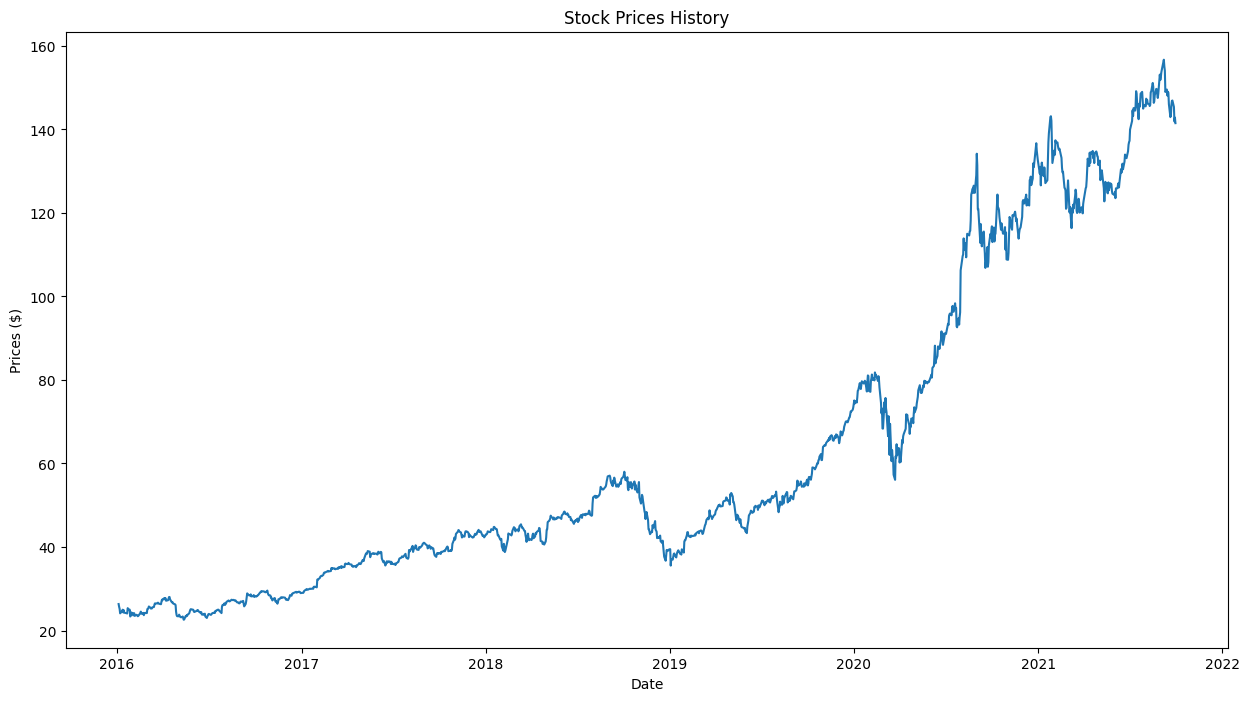

In [3]:
# Prior to preparing to build a LSTM model, let’s take a look at the historical prices movement of AAPL by plotting a line chart.

#Set the plot figure size and title.
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')

# Use the Matplotlib plot method to create a line chart for historical close prices of AAPL.
plt.plot(stock_data['Close'])

# Set the x-axis and y-axis labels.
plt.xlabel('Date')
plt.ylabel('Prices ($)')

3. Data Preprocessing

In [4]:
#To build a LSTM model, we need to separate our stock prices data into a training set and a test set. 
#Besides, we will also normalize our data so that all the values are ranged from 0 to 1.

3.1 Preparation of training set

In [5]:
#Here we will only need the closing prices from our dataset to train our LSTM model. 
#We are going to extract 80% of the closing prices from our acquired stock data as our training set.

In [6]:
# Extract the closing prices from the acquired stock data and convert it to a number series.
close_prices = stock_data['Close']
values = close_prices.values

# Calculate the data size for 80% of the dataset. The math.ceil method is to ensure the data size is rounded up to an integer.
training_data_len = math.ceil(len(values)* 0.8)

# Use the Scikit-Learn MinMaxScaler to normalize all our stock data ranging from 0 to 1. 
# We also reshape our normalized data into a two-dimensional array.
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

# Set apart the first 80% of the stock data as the training set.
train_data = scaled_data[0: training_data_len, :]

# Create an empty list for a sequence of feature data (x_train) and a sequence of label data (y_train).
x_train = []
y_train = []

# Create a 60-days window of historical prices (i-60) as our feature data (x_train) 
# and the following 60-days window as label data (y_train).
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the feature data (x_train) and label data (y_train) into Numpy array as it is the data format accepted by the Tensorflow 
# when training a neural network model. Reshape again the x_train and y_train into a three-dimensional array as part of 
# the requirement to train a LSTM model.
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


3.2 Preparation of test set

In [7]:
# Next, we will proceed to prepare a test set.

In [8]:
# Extract the closing prices from our normalized dataset (the last 20% of the dataset).
test_data = scaled_data[training_data_len-60: , : ]

# Similar to the training set, we will have to create feature data (x_test) and label data (y_test)from our test set.
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

# Convert the feature data (x_test) and label data (y_test) into Numpy array. 
# Reshape again the x_test and y_test into a three-dimensional array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

3.3 Setting Up LSTM Network Architecture

In [9]:
# Now, we are ready to use an open-source machine learning library, Tensorflow, to set up our LSTM network architecture.

In [10]:
# Define a Sequential model which consists of a linear stack of layers.
model = keras.Sequential()

# Add a LSTM layer by giving it 100 network units. 
# Set the return_sequence to true so that the output of the layer will be another sequence of the same length.
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))

# Add another LSTM layer with also 100 network units.
# But we set the return_sequence to false for this time to only return the last output in the output sequence.
model.add(layers.LSTM(100, return_sequences=False))

# Add a densely connected neural network layer with 25 network units.
model.add(layers.Dense(25))

# At last, add a densely connected layer that specifies the output of 1 network unit.
model.add(layers.Dense(1))

# Show the summary of our LSTM network architecture.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


3.4 Training LSTM Model

In [11]:
# At this stage, we are almost ready to train our LSTM model by fitting it with the training set. 
# Prior to that, we have to set an optimizer and a loss function for our model.

In [18]:
# Adopt “adam” optimizer and set the mean square error as loss function.
model.compile(optimizer='adam', loss='mean_squared_error')
# La taille de lot détermine le nombre de séquences d'entraînement qui sont utilisées 
# pour mettre à jour les poids du modèle à chaque itération de l'entraînement. 
# Le nombre d'époques détermine le nombre de fois que l'ensemble des données d'entraînement sera utilisé pour entraîner le modèle.


# Train the model by fitting it with the training set. We can try with batch_size of 1 and run the training for 3 epochs.
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
1098/1098 [==============================] - 41s 32ms/step - loss: 3.2569e-04
Epoch 2/3
1098/1098 [==============================] - 34s 31ms/step - loss: 2.3683e-04
Epoch 3/3
1098/1098 [==============================] - 35s 32ms/step - loss: 2.8536e-04


3.5 Model Evaluation

In [13]:
# Our next task is to evaluate our trained LSTM model with the test set and then apply the root mean square error 
# (RMSE) metric to examine the performance of the model.

In [19]:
# Apply the model to predict the stock prices based on the test set.
predictions = model.predict(x_test)

# Use the inverse_transform method to denormalize the predicted stock prices.
predictions = scaler.inverse_transform(predictions)

# Apply the RMSE formula to calculate the degree of discrepancy 
# between the predicted prices and real prices (y_test) and display the result.
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

10/10 [==============================] - 2s 34ms/step


1.6719968591181877

3.6 Visualizing the Predicted Prices

In [20]:
# It is always helpful to visualize the predicted prices in a graphical way. 
# Here we are going to plot our predicted stock price and the real stock price using the Python Matplolib again.

C:\Users\zertyui\AppData\Local\Temp\ipykernel_2472\1961106032.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


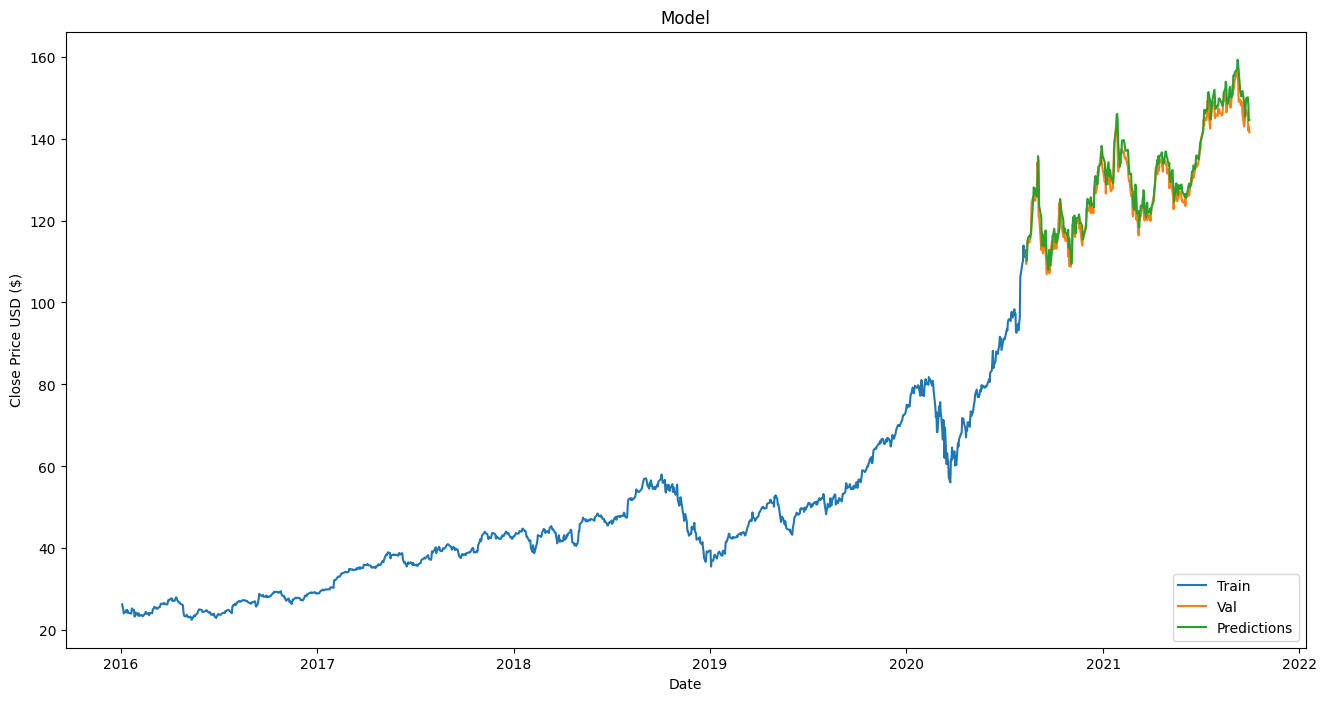

In [21]:
# Use the filter method to only retain the closing price column in the dataframe.
data = stock_data.filter(['Close'])

# Split our stock data into three plotting regions: training, validation and prediction.
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions

# Configure the chart figure size, title, x-axis & y-axis label and legends.
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [22]:
# From the resulting chart above, we can see the predicted stock prices follow the trend of the real stock prices closely. 
# This shows the effectiveness of the LSTM to work with time series or sequential data like the stock prices.